In [16]:
import keras

In [17]:
import keras
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

In [18]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [19]:
# 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻습니다
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [20]:
# 이 텐서는 생성된 딥드림 이미지를 저장합니다
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산합니다
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화합니다(이 기교가 중요합니다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만듭니다
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [21]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [27]:
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = 'C:/Users/Woody/Desktop/IEPL9264.png'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./datasets/final_dream.png')

처리할 이미지 크기 (183, 183)
... 0 번째 손실 : 1.5900131
... 1 번째 손실 : 2.0408347
... 2 번째 손실 : 2.698308
... 3 번째 손실 : 3.305719
... 4 번째 손실 : 3.850703
... 5 번째 손실 : 4.311364
... 6 번째 손실 : 4.8255653
... 7 번째 손실 : 5.3537774
... 8 번째 손실 : 5.7678576
... 9 번째 손실 : 6.2674904
... 10 번째 손실 : 6.7199874
... 11 번째 손실 : 7.1037645
... 12 번째 손실 : 7.503235
... 13 번째 손실 : 7.9438963
... 14 번째 손실 : 8.330278
... 15 번째 손실 : 8.724032
... 16 번째 손실 : 9.115017
... 17 번째 손실 : 9.498713
... 18 번째 손실 : 9.745386
처리할 이미지 크기 (257, 257)
... 0 번째 손실 : 2.8655868
... 1 번째 손실 : 4.19633
... 2 번째 손실 : 5.312329
... 3 번째 손실 : 6.3836284
... 4 번째 손실 : 7.28377
... 5 번째 손실 : 8.164759
... 6 번째 손실 : 8.879457
... 7 번째 손실 : 9.520153
처리할 이미지 크기 (360, 360)
... 0 번째 손실 : 2.970292
... 1 번째 손실 : 4.147046
... 2 번째 손실 : 5.147934
... 3 번째 손실 : 6.095236
... 4 번째 손실 : 6.9577584
... 5 번째 손실 : 7.780128
... 6 번째 손실 : 8.620853
... 7 번째 손실 : 9.470374


In [28]:
from matplotlib import pyplot as plt

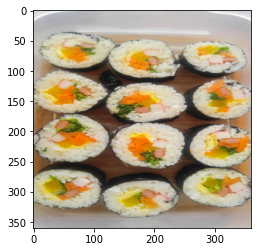

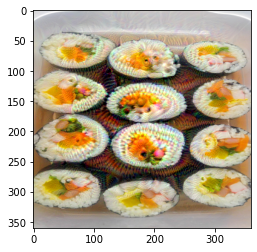

In [29]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()